<a href="https://colab.research.google.com/github/everestial/TestSwitchErrors/blob/fix-scripts/Scripts/SwitchErrorTest_PhaseExtenderSetA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
getwd()

[1] "/Users/bhuwanaryal/Desktop/projects/bioinformatics/TestSwitchErrors/Scripts/notebook"

In [2]:
setwd("../..")
list.files()

[1] "HapMap3_r2_b36_2009.zip"                       
 [2] "README.md"                                     
 [3] "Rplots.pdf"                                    
 [4] "Scripts"                                       
 [5] "SwitchPoints_SetA02_withOutHaplotypeBreaks.png"
 [6] "data"                                          
 [7] "makeHapFile.py"                                
 [8] "merge_haplotypePandas.py"                      
 [9] "phase-Extender.py"                             
[10] "phase-Extender2.py"                            
[11] "plot_haplotype_stats.py"                       
[12] "requirements.txt"                              
[13] "temp5"                                         
[14] "temp6"                                         
[15] "tests"                                         
[16] "vcf_to_table-v2.py"

In [3]:
truthHaplotype_NA12891 <- read.table('data/SetA/truth_Haplotype_NA12891.txt', header = TRUE)
head(truthHaplotype_NA12891)

,CHROM,POS,NA12891.PI,NA12891.PG_al
,<int>,<int>,<dbl>,<chr>
1,20,9795,1,T|G
2,20,11799,1,T|C
3,20,17094,1,A|G
4,20,24962,1,C|T
5,20,28655,1,G|A
6,20,35416,1,C|A


In [4]:

# change the name of the header
colnames(truthHaplotype_NA12891)[colnames(truthHaplotype_NA12891)=="NA12891.PI"] <- "true.NA12891.PI"
colnames(truthHaplotype_NA12891)[colnames(truthHaplotype_NA12891)=="NA12891.PG_al"] <- "true.NA12891.PG_al"


In [5]:
head(truthHaplotype_NA12891)

,CHROM,POS,true.NA12891.PI,true.NA12891.PG_al
,<int>,<int>,<dbl>,<chr>
1,20,9795,1,T|G
2,20,11799,1,T|C
3,20,17094,1,A|G
4,20,24962,1,C|T
5,20,28655,1,G|A
6,20,35416,1,C|A


In [6]:
## Import "phased haplotype" for data/SetA
phased_SetA_NA12891 <- read.table('data/SetA/phased_NA12891_SetA_run01/extended_haplotype_NA12891.txt', header = TRUE)
# or, we can use the file "extended_haplotype_NA12891.txt" from the folder "/data/SetA/phased_NA12891_SetA_run01/"
head(phased_SetA_NA12891)

,CHROM,POS,REF,all.alleles,NA12891.PI,NA12891.PG_al,log2odds
,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,20,9795,G,"G,T",1,T|G,.
2,20,11799,C,"C,T",1,T|C,.
3,20,17094,A,"A,G",1,A|G,.
4,20,24962,C,"C,T",1,C|T,.
5,20,28655,A,"A,G",1,G|A,.
6,20,35416,A,"A,C",1,C|A,-35.17318


In [7]:
colnames(phased_SetA_NA12891)[colnames(phased_SetA_NA12891)=="NA12891.PI"] <- "phased.NA12891.PI"
colnames(phased_SetA_NA12891)[colnames(phased_SetA_NA12891)=="NA12891.PG_al"] <- "phased.NA12891.PG_al"


## Merge the truth and phased data set to identify switch errors
merged.data <- merge(truthHaplotype_NA12891, phased_SetA_NA12891,
                     by=c("CHROM", "POS"))
head(merged.data)

,CHROM,POS,true.NA12891.PI,true.NA12891.PG_al,REF,all.alleles,phased.NA12891.PI,phased.NA12891.PG_al,log2odds
,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,20,10003480,270,T|G,G,"G,T",387,G|T,31.61731
2,20,10007072,270,A|C,A,"A,C",387,C|A,31.61731
3,20,10008681,270,C|T,C,"C,T",387,T|C,31.61731
4,20,10012529,270,G|A,A,"A,G",387,A|G,-15.84963
5,20,10015264,270,A|G,A,"A,G",387,G|A,-15.84963
6,20,10016488,271,T|C,C,"C,T",387,C|T,-15.84963


In [8]:
merged.data <- merged.data[order(merged.data$POS),]

In [9]:
rownames(merged.data) <- NULL

In [10]:
# Now, compare the "truth haplotype" with "phased haplotype" and ...
# ... find the sites where haplotype phasing switched
merged.data$match <- ifelse((merged.data$true.NA12891.PG_al == merged.data$phased.NA12891.PG_al), 0, 1)

In [11]:
dev.new(width = 550, height = 330, unit = "px")

quartz_off_screen 
                4

pdf 
  2

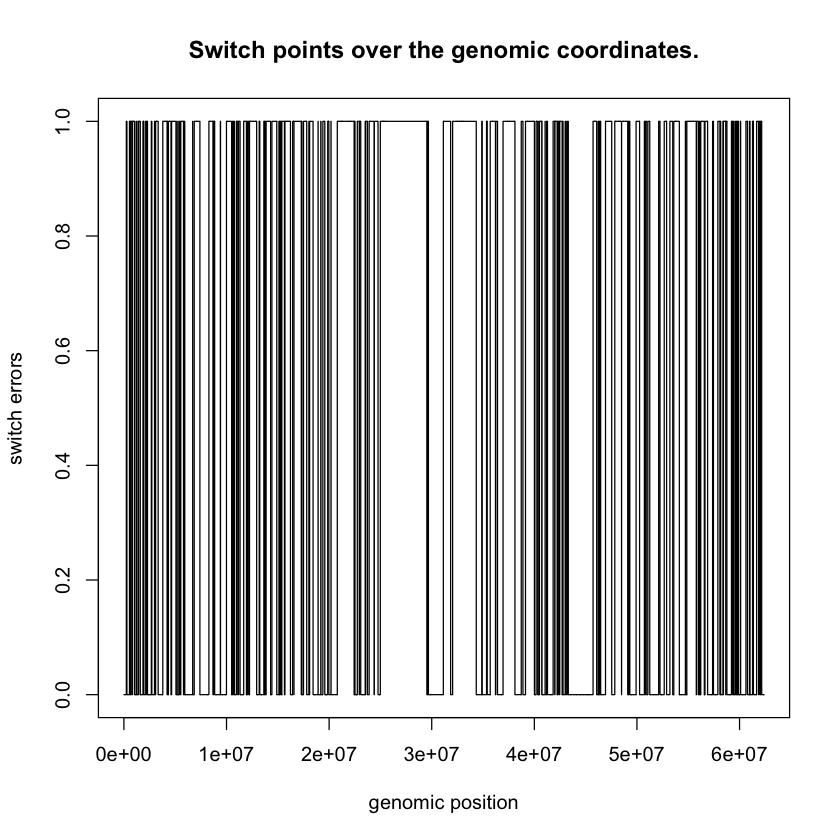

In [12]:
filename <- "data/rplots/SwitchPoints_SetA_withOutHaplotypeBreaks.png"
plot(merged.data$POS, merged.data$match, main = "Switch points over the genomic coordinates.", type = "s", 
     xlab = "genomic position", ylab = "switch errors")
dev.copy(device = png, filename = filename, width = 1600, height = 600)
dev.off()

In [13]:

# Compute switch error rates 
number_of_hets <- length(merged.data$match)
num_of_switch <- 0
prev_match <- merged.data$match[1]
for (item in merged.data$match){
  curr_match = item
  if (curr_match != prev_match){
    num_of_switch = num_of_switch + 1
    
    # reset the "previous match" value
    prev_match = curr_match}}

switch_err_rate = num_of_switch/(number_of_hets)
switch_err_rate

[1] 0.0306228

In [14]:
## So, now we compute switch point by including changes in "PI" values.
# Now, the "switch points" are addressed when :
  # we see 0 -> 1, or when 1 -> 0 in the "match" data
  # PI of the haplotype block changes
    # ** So, now we need to account for the match and also for change in haplotype block index.

# the length (number of rows) of the dataframe
seq_len <- length(merged.data$match)
seq_len


[1] 9666

In [15]:
# set empty variables 
previous_match <- 0
hap_size <- 0
haplotype_sizes <- integer()  # to store the size of haplotype extended truly.
previous_pi <- 1 
haplotype_breaks <- integer()

In [16]:

# run a for loop to find switch points 
for (ith in c(1:seq_len)){
  current_match = merged.data$match[ith]
  current_pi = merged.data$phased.NA12891.PI[ith]
  if (previous_match == current_match & previous_pi == current_pi) {
    hap_size = hap_size + 1}
  else if (previous_match != current_match | previous_pi != current_pi) {
    # store the haplotype size of properly phased (extended) block
    haplotype_sizes <- c(haplotype_sizes, hap_size)
    hap_size <- 1}  # reset the haplotype size to 1
  
  # store the last haplotype size when the for loop reaches the end
  if (ith == seq_len){
    haplotype_sizes <- c(haplotype_sizes, hap_size)}
  
  # also find the genomic positions where haplotype breaks occur 
  if (previous_pi != current_pi){
    haplotype_breaks <- c(haplotype_breaks, merged.data$POS[ith])}
  
  # update the previous match and pi values for next for-loop 
  previous_match = current_match
  previous_pi = current_pi }

In [17]:

## Identify switch points and compute "switch error" rates. 
# the total number of haplotype blocks represent frequecy of switch points
freq_of_switch = length(haplotype_sizes)
total_possible_switch = sum(haplotype_sizes) # or number of hets site
haplotype_sizes

[1]  17  15  19   4  19   6   7   5   5  14   7   6  22   5  18   4   5  24
 [19]   8   5  34   5   4  14  42  18   7  11  10   9   8   3  40  17  12   3
 [37]   6   4  28  22  14  15   9  51   4   4   8   3  46   6   5  39  38  39
 [55]  28  58   4   3   3  30  16  22   5  10  67  22   4  33  11   8   7  17
 [73]   5  38  35   6   3  52   7  21  22   7   4   4  10  19  58  83  13  81
 [91]  38  42  14  63  34   4   4   5  44  24  24  22  72   5  23   8   5   4
[109]  51  37  15  33  57  44  27   8  26   5   5   5  26  15   6  13 111  22
[127]   9  10  29  48  28   8  10  21   7  17   6   4   4  19  14  24  32  21
[145]  40  27   4  15   7  29  17  26   8  19   7   7   3   6  56  95  46   3
[163]  35   3  25  18   6   6  17  32  13  76  15   6   4  17  37   6  10  15
[181]   7  43   3   9   3   9  25  39  21  12  14  40   4  80  88 144  27   5
[199]   8   6   3   5   5  85  16   9   8   4  27  94  16   5  29   6   4  32
[217]   4   9   4  43  23 184   4   6   4   5   5   3   4   6   3  51   9  60
[235]   9  29  21 195  13  43  10   9  34  14   8  36   5  63  15  14  25   9
[253]  46  22 107   3  44   7  17  31  15  60  19  20  70  54  20   3   5   4
[271]   5  16   8  48   8   4  24  20   8   7   4  25   6   5  81  13   6   5
[289]   6  72   8   4   5   3   4  22  54  11   6   9   8   3   4   3   4  48
[307]  21  49 149  68  20  18   4  18  11   7   4  38   8   6  17   4 140   4
[325]  11  84   5   7  25  11   4  20  24  23   8  27  17   5  10   7   5   4
[343]  20  19   4  12   6  14  35  21  80  12  35   9   4  14  37  13   9   8
[361]  22 143   3  22  40  41   3   4  16  26  70  31  81  21   4  72  24   3
[379]  19   5  25  25  12  14  25   9  14  20  29   7   6   3   7   6  46  13
[397]   4   5   7   5   5   5   5   7   5   5  63   5   7  13  27   3  10  79
[415]  15  39  20  23   6   4   6   6  12  17   6  14   9  40   4  11  28  47
[433]   3  12  23   7  23   4  34  12   4  24  57  15   8   8   5  17   4  24
[451]  24

In [18]:
# calculate switch error rate
switch_error_rate = (freq_of_switch/total_possible_switch)
switch_error_rate

[1] 0.04665839

In [19]:
## Now, add another column that represent the fully accounted haplotype switchpoints.
phase_state = 0
match_by_pi <- integer()
for (sizes in haplotype_sizes) {
  match_by_pi <- c(match_by_pi, rep(phase_state, sizes))
  
  # change the phase state for next loop
  if (phase_state == 0){
    phase_state = 1}
  else if (phase_state == 1){
    phase_state = 0} }

In [20]:

## add data "match02" to the dataframe
merged.data$match_by_pi <- match_by_pi


## Now, make switch points plot by accounting for the haplotype breaks. 
# for that we will create another column with updated matches between truth and phased haplotypes

quartz_off_screen 
                4

pdf 
  2

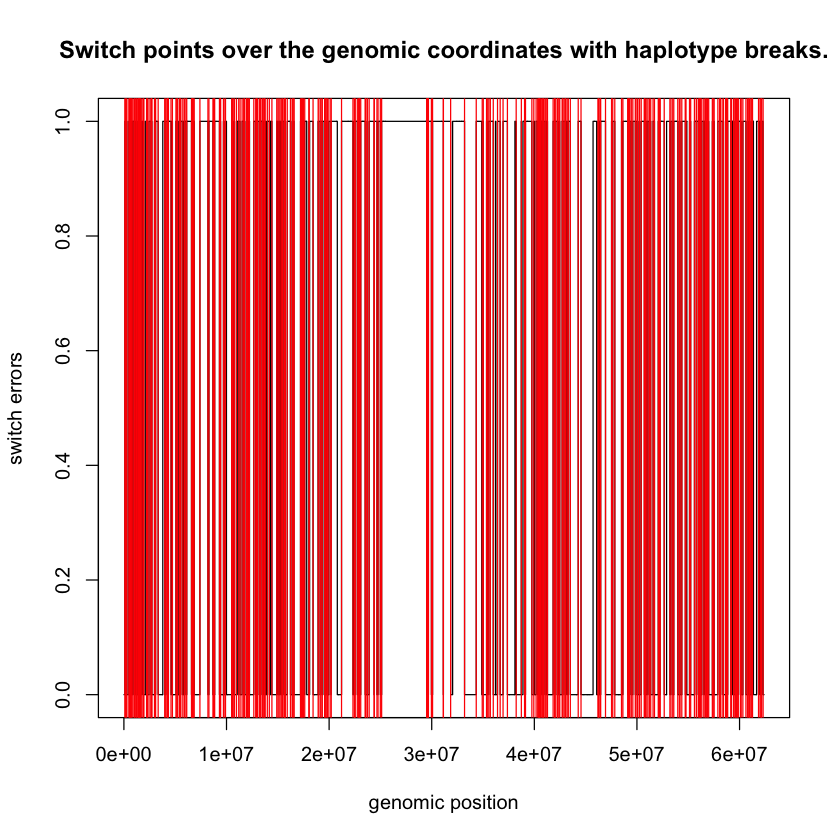

In [21]:
filename <- "data/rplots/SwitchPoints_SetA_withHaplotypeBreaks.png"

plot(merged.data$POS, merged.data$match_by_pi, main = "Switch points over the genomic coordinates with haplotype breaks.", type = "s", 
     xlab = "genomic position", ylab = "switch errors")
abline(v=haplotype_breaks, col='red')
dev.copy(device = png, filename = filename, width = 1600, height = 600)
dev.off()

## We can now overlay the haplotype breaks position on the top of switch points plot for convenience let's convert this haplotype size list into integer array

In [22]:
haplotype_size_numeric <- as.numeric(unlist(haplotype_sizes))
haplotype_size_numeric

[1]  17  15  19   4  19   6   7   5   5  14   7   6  22   5  18   4   5  24
 [19]   8   5  34   5   4  14  42  18   7  11  10   9   8   3  40  17  12   3
 [37]   6   4  28  22  14  15   9  51   4   4   8   3  46   6   5  39  38  39
 [55]  28  58   4   3   3  30  16  22   5  10  67  22   4  33  11   8   7  17
 [73]   5  38  35   6   3  52   7  21  22   7   4   4  10  19  58  83  13  81
 [91]  38  42  14  63  34   4   4   5  44  24  24  22  72   5  23   8   5   4
[109]  51  37  15  33  57  44  27   8  26   5   5   5  26  15   6  13 111  22
[127]   9  10  29  48  28   8  10  21   7  17   6   4   4  19  14  24  32  21
[145]  40  27   4  15   7  29  17  26   8  19   7   7   3   6  56  95  46   3
[163]  35   3  25  18   6   6  17  32  13  76  15   6   4  17  37   6  10  15
[181]   7  43   3   9   3   9  25  39  21  12  14  40   4  80  88 144  27   5
[199]   8   6   3   5   5  85  16   9   8   4  27  94  16   5  29   6   4  32
[217]   4   9   4  43  23 184   4   6   4   5   5   3   4   6   3  51   9  60
[235]   9  29  21 195  13  43  10   9  34  14   8  36   5  63  15  14  25   9
[253]  46  22 107   3  44   7  17  31  15  60  19  20  70  54  20   3   5   4
[271]   5  16   8  48   8   4  24  20   8   7   4  25   6   5  81  13   6   5
[289]   6  72   8   4   5   3   4  22  54  11   6   9   8   3   4   3   4  48
[307]  21  49 149  68  20  18   4  18  11   7   4  38   8   6  17   4 140   4
[325]  11  84   5   7  25  11   4  20  24  23   8  27  17   5  10   7   5   4
[343]  20  19   4  12   6  14  35  21  80  12  35   9   4  14  37  13   9   8
[361]  22 143   3  22  40  41   3   4  16  26  70  31  81  21   4  72  24   3
[379]  19   5  25  25  12  14  25   9  14  20  29   7   6   3   7   6  46  13
[397]   4   5   7   5   5   5   5   7   5   5  63   5   7  13  27   3  10  79
[415]  15  39  20  23   6   4   6   6  12  17   6  14   9  40   4  11  28  47
[433]   3  12  23   7  23   4  34  12   4  24  57  15   8   8   5  17   4  24
[451]  24

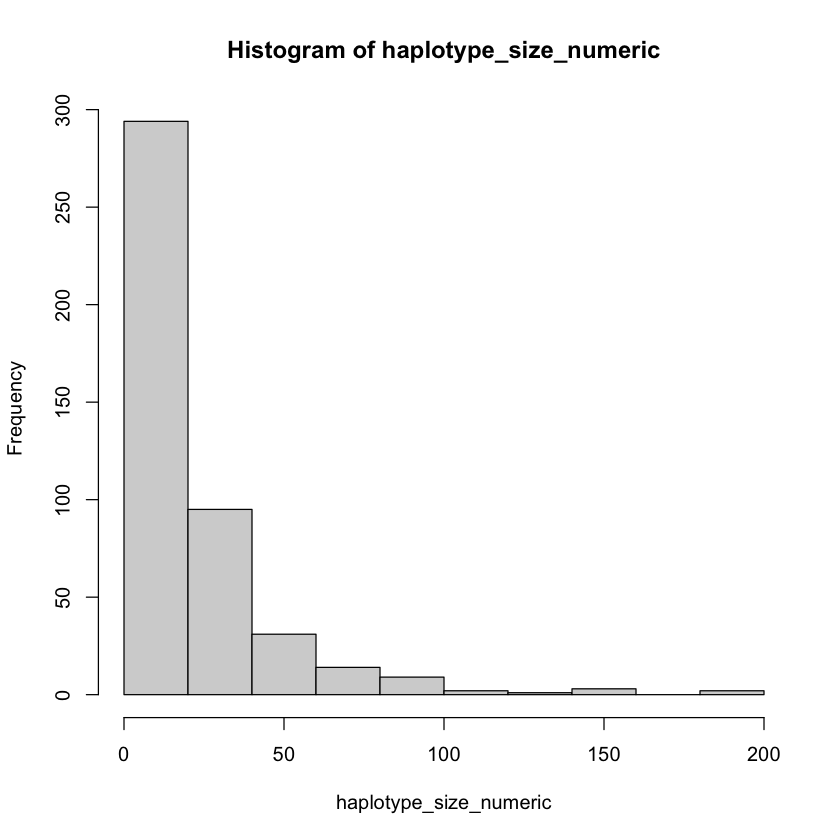

quartz_off_screen 
                4

pdf 
  2

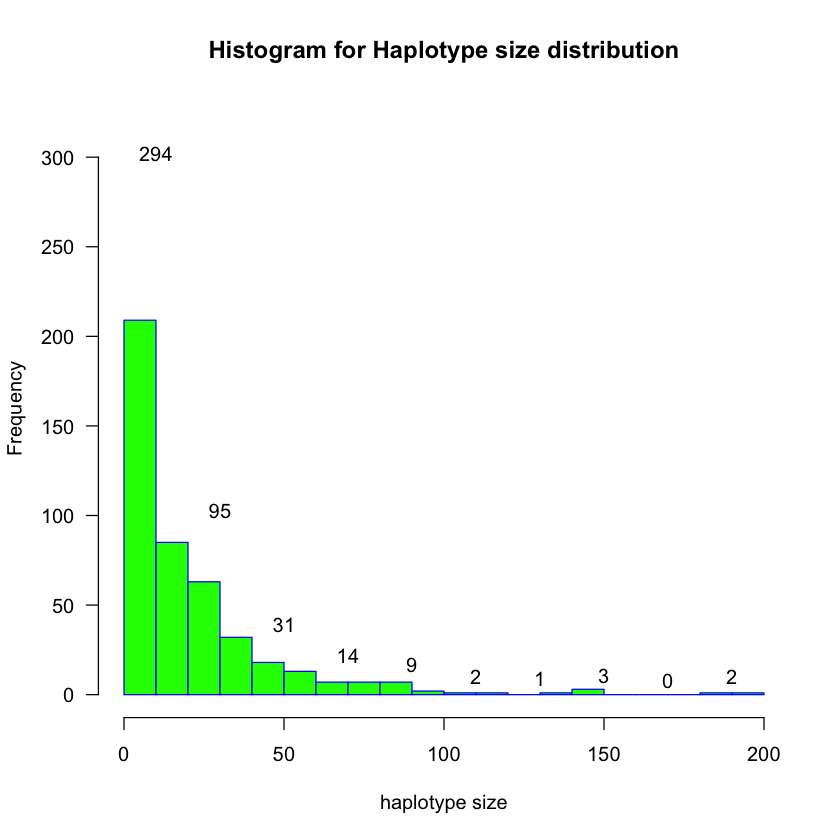

In [23]:
## Let's plot a histogram of the haplotype size distribution 
hisHap <- hist(haplotype_size_numeric)  # general histogram metrics for the data 
filename <- "data/rplots/Histogram_ofHaplotypeSizeDistribution_SetA.png"
hist(haplotype_size_numeric, 
     main="Histogram for Haplotype size distribution", 
     xlab="haplotype size", 
     border="blue", 
     col="green",
     xlim=c(0,200),
     ylim = c(0,320),
     las=1, 
     breaks=20)
# add the size of the frequency to the histogram plot 
text(hisHap$mids,hisHap$counts,labels=hisHap$counts, adj=c(0.5, -0.5))
dev.copy(device = png, filename = filename, width = 1600, height = 600)
dev.off()

quartz_off_screen 
                4

pdf 
  2

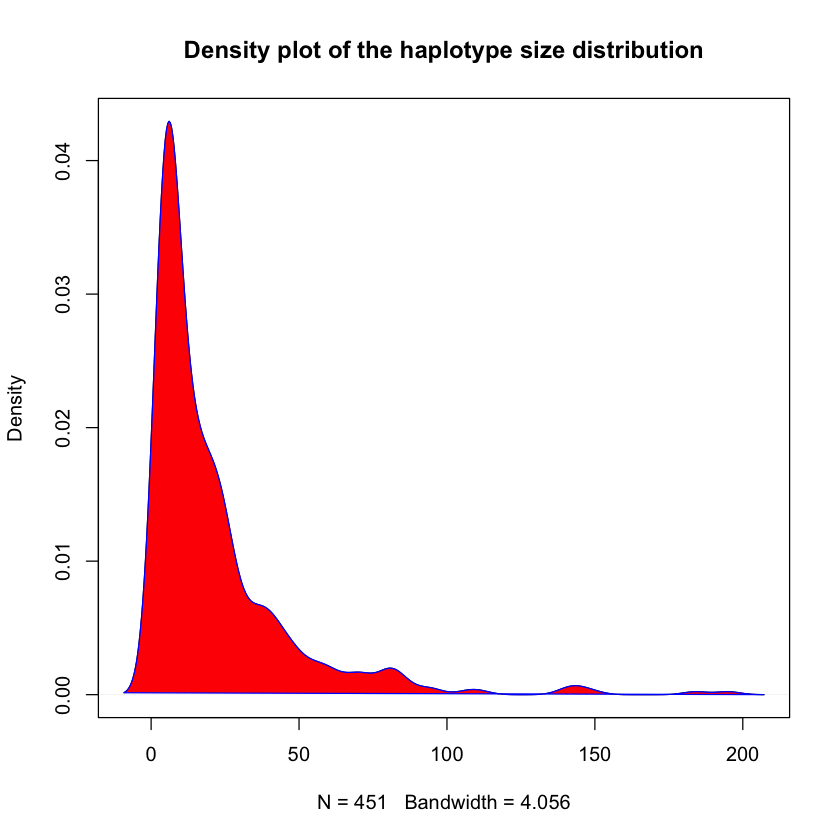

In [24]:
## Density plot
densHap <- density(haplotype_size_numeric)
filename <- "data/rplots/DensityPlot_ofHaplotypeSizeDistribution_SetA.png"
plot(densHap, main = "Density plot of the haplotype size distribution")
polygon(densHap, col = 'red', border = 'blue')
dev.copy(device = png, filename = filename, width = 1600, height = 600)

dev.off()

# print("Completed the switch error analyses on first round of phaseExtension on Set-A data.")